# Statistical Significance Testing

This notebook performs rigorous statistical tests to validate that our model performance is:
1. **Significantly better than chance** (permutation test)
2. **Reliable** (bootstrap confidence intervals)
3. **Significantly different between models** (McNemar's test)
4. **Affected by ambiguity level** (repeated measures ANOVA)

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [4]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

print(f"\n{'='*70}")
print(f"STATISTICAL SIGNIFICANCE TESTING: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


STATISTICAL SIGNIFICANCE TESTING: PRE-DECISION PERIOD



In [5]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style('whitegrid')
np.random.seed(42)

## Load Decision Results

In [6]:
# Load features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

data = feature_data['merged_df']

print(f"Total trials: {len(data)}")
print(f"Subjects: {data['subject_id'].nunique()}")
print(f"Outcome distribution: {data['outcome'].value_counts().to_dict()}")
print(f"\nClass balance: {data['outcome'].value_counts()[0]/len(data):.1%} / {data['outcome'].value_counts()[1]/len(data):.1%}")
print(f"\n⚠️  NOTE: Using class_weight='balanced' to handle class imbalance")
print(f"   This will give different results than other notebooks without class balancing")

Total trials: 12511
Subjects: 97
Outcome distribution: {1: 8238, 0: 4273}

Class balance: 34.2% / 65.8%

⚠️  NOTE: Using class_weight='balanced' to handle class imbalance
   This will give different results than other notebooks without class balancing


## 1. Permutation Test: Better Than Chance?

**Null hypothesis:** Model accuracy = 50% (chance)

**Method:** Shuffle labels 1000 times, recompute accuracy, compare to observed

In [7]:
def permutation_test(X, y, subjects, n_permutations=1000, model_name="Model"):
    """
    Optimized permutation test to assess if accuracy is significantly > chance.
    
    Uses class_weight='balanced' to handle class imbalance properly.
    Tests against 50% random chance baseline.
    """
    print(f"\n{'='*70}")
    print(f"Permutation Test: {model_name}")
    print(f"{'='*70}")
    
    # Get true accuracy using LOSO CV
    logo = LeaveOneGroupOut()
    true_accs = []
    
    print("Computing true accuracy with class_weight='balanced'...")
    for train_idx, test_idx in tqdm(logo.split(X, y, subjects), 
                                     total=len(np.unique(subjects)),
                                     desc="True LOSO folds"):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Use class_weight='balanced' to handle imbalance
        model = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                      min_samples_split=10, min_samples_leaf=5,
                                      class_weight='balanced',
                                      random_state=42, n_jobs=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        true_accs.append(accuracy_score(y_test, y_pred))
    
    true_accuracy = np.mean(true_accs)
    print(f"True Accuracy: {true_accuracy:.4f}")
    
    # Permutation test: shuffle labels to break feature-label relationship
    print(f"\nRunning {n_permutations} permutations...")
    print("Testing against 50% chance baseline (with balanced classes)")
    
    null_accs = []
    
    for i in tqdm(range(n_permutations), desc="Permutations"):
        # Randomly shuffle ALL labels (breaks feature-label relationship)
        y_shuffled = np.random.permutation(y)
        
        # Sample subset of subjects for speed
        unique_subjects = np.unique(subjects)
        sample_size = min(20, len(unique_subjects))
        sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)
        sampled_mask = np.isin(subjects, sampled_subjects)
        
        X_sample = X[sampled_mask]
        y_sample = y_shuffled[sampled_mask]
        subjects_sample = subjects[sampled_mask]
        
        # Run LOSO CV with shuffled labels
        perm_accs = []
        for train_idx, test_idx in logo.split(X_sample, y_sample, subjects_sample):
            X_train, X_test = X_sample[train_idx], X_sample[test_idx]
            y_train, y_test = y_sample[train_idx], y_sample[test_idx]
            
            # Use class_weight='balanced'
            model = RandomForestClassifier(n_estimators=50, max_depth=5,
                                          min_samples_split=10, min_samples_leaf=5,
                                          class_weight='balanced',
                                          random_state=i, n_jobs=1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            perm_accs.append(accuracy_score(y_test, y_pred))
        
        null_accs.append(np.mean(perm_accs))
    
    # Compute p-value
    p_value = np.mean(np.array(null_accs) >= true_accuracy)
    
    print(f"\nNull Distribution Mean: {np.mean(null_accs):.4f} (should be ~50%)")
    print(f"Null Distribution Std: {np.std(null_accs):.4f}")
    print(f"True Accuracy: {true_accuracy:.4f}")
    print(f"\np-value: {p_value:.4f}")
    
    if p_value < 0.001:
        print(f"✓ {model_name} is HIGHLY SIGNIFICANT (p < 0.001)")
    elif p_value < 0.01:
        print(f"✓ {model_name} is VERY SIGNIFICANT (p < 0.01)")
    elif p_value < 0.05:
        print(f"✓ {model_name} is SIGNIFICANT (p < 0.05)")
    else:
        print(f"✗ {model_name} is NOT SIGNIFICANT (p = {p_value:.4f})")
    
    return {
        'true_accuracy': true_accuracy,
        'null_mean': np.mean(null_accs),
        'null_std': np.std(null_accs),
        'p_value': p_value,
        'null_distribution': null_accs
    }

In [8]:
# Define feature groups
if TIMEFRAME == 'PRE':
    physiology_features = [
        'pupil_mean_pre', 'pupil_std_pre', 'pupil_slope_pre', 'time_to_peak_pre', 
        'pupil_cv_pre', 'pupil_velocity_mean_pre', 'pupil_max_dilation_rate_pre',
        'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre',
        'pct_time_dilating_pre', 'num_dilation_peaks_pre', 'eye_asymmetry_pre', 
        'eye_asymmetry_std_pre'
    ]
else:
    physiology_features = [
        'pupil_mean_post', 'pupil_std_post', 'pupil_slope_post', 'time_to_peak_post', 
        'pupil_cv_post', 'pupil_velocity_mean_post', 'pupil_max_dilation_rate_post',
        'pupil_max_constriction_rate_post', 'pupil_acceleration_std_post',
        'pct_time_dilating_post', 'num_dilation_peaks_post', 'eye_asymmetry_post', 
        'eye_asymmetry_std_post'
    ]

gaze_features = [
    'gaze_valid_pct', 'gaze_x_mean', 'gaze_x_std', 'gaze_y_mean', 'gaze_y_std',
    'screen_x_mean', 'screen_x_std', 'screen_y_mean', 'screen_y_std',
    'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max',
    'gaze_acceleration_mean', 'gaze_acceleration_std',
    'fixation_ratio', 'saccade_ratio', 'saccade_count',
    'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length'
]

behavior_features = [
    'reaction_time', 'decision_time', 'ev_difference',
    'invest_variance', 'ambiguity', 'condition_social', 'risk_premium'
]

# Filter available features
available_physiology = [f for f in physiology_features if f in data.columns]
available_gaze = [f for f in gaze_features if f in data.columns]
available_behavior = [f for f in behavior_features if f in data.columns]

print(f"Physiology features: {len(available_physiology)}/{len(physiology_features)}")
print(f"Gaze features: {len(available_gaze)}/{len(gaze_features)}")
print(f"Behavior features: {len(available_behavior)}/{len(behavior_features)}")

# Prepare data for all modalities
X_physiology = SimpleImputer(strategy='mean').fit_transform(data[available_physiology])
X_gaze = SimpleImputer(strategy='mean').fit_transform(data[available_gaze])
X_behavior = SimpleImputer(strategy='mean').fit_transform(data[available_behavior])
X_phys_gaze = SimpleImputer(strategy='mean').fit_transform(data[available_physiology + available_gaze])
X_all = SimpleImputer(strategy='mean').fit_transform(data[available_physiology + available_gaze + available_behavior])

y = data['outcome'].values
subjects = data['subject_id'].values

print(f"\nDataset shapes:")
print(f"  Physiology: {X_physiology.shape}")
print(f"  Gaze: {X_gaze.shape}")
print(f"  Behavior: {X_behavior.shape}")
print(f"  Physiology + Gaze: {X_phys_gaze.shape}")
print(f"  All features: {X_all.shape}")

Physiology features: 13/13
Gaze features: 20/20
Behavior features: 7/7

Dataset shapes:
  Physiology: (12511, 13)
  Gaze: (12511, 20)
  Behavior: (12511, 7)
  Physiology + Gaze: (12511, 33)
  All features: (12511, 40)


In [9]:
# Run permutation tests on all modalities
print("="*70)
print("RUNNING PERMUTATION TESTS FOR ALL MODALITIES")
print("="*70)

perm_results = {}

perm_results['all'] = permutation_test(
    X_all, y, subjects, 
    n_permutations=1000, 
    model_name=f"All Features ({TIMEFRAME})"
)

RUNNING PERMUTATION TESTS FOR ALL MODALITIES

Permutation Test: All Features (PRE)
Computing true accuracy with class_weight='balanced'...


True LOSO folds: 100%|██████████| 97/97 [01:28<00:00,  1.10it/s]


True Accuracy: 0.6423

Running 1000 permutations...
Testing against 50% chance baseline (with balanced classes)


Permutations: 100%|██████████| 1000/1000 [57:24<00:00,  3.44s/it]


Null Distribution Mean: 0.5462 (should be ~50%)
Null Distribution Std: 0.0181
True Accuracy: 0.6423

p-value: 0.0000
✓ All Features (PRE) is HIGHLY SIGNIFICANT (p < 0.001)


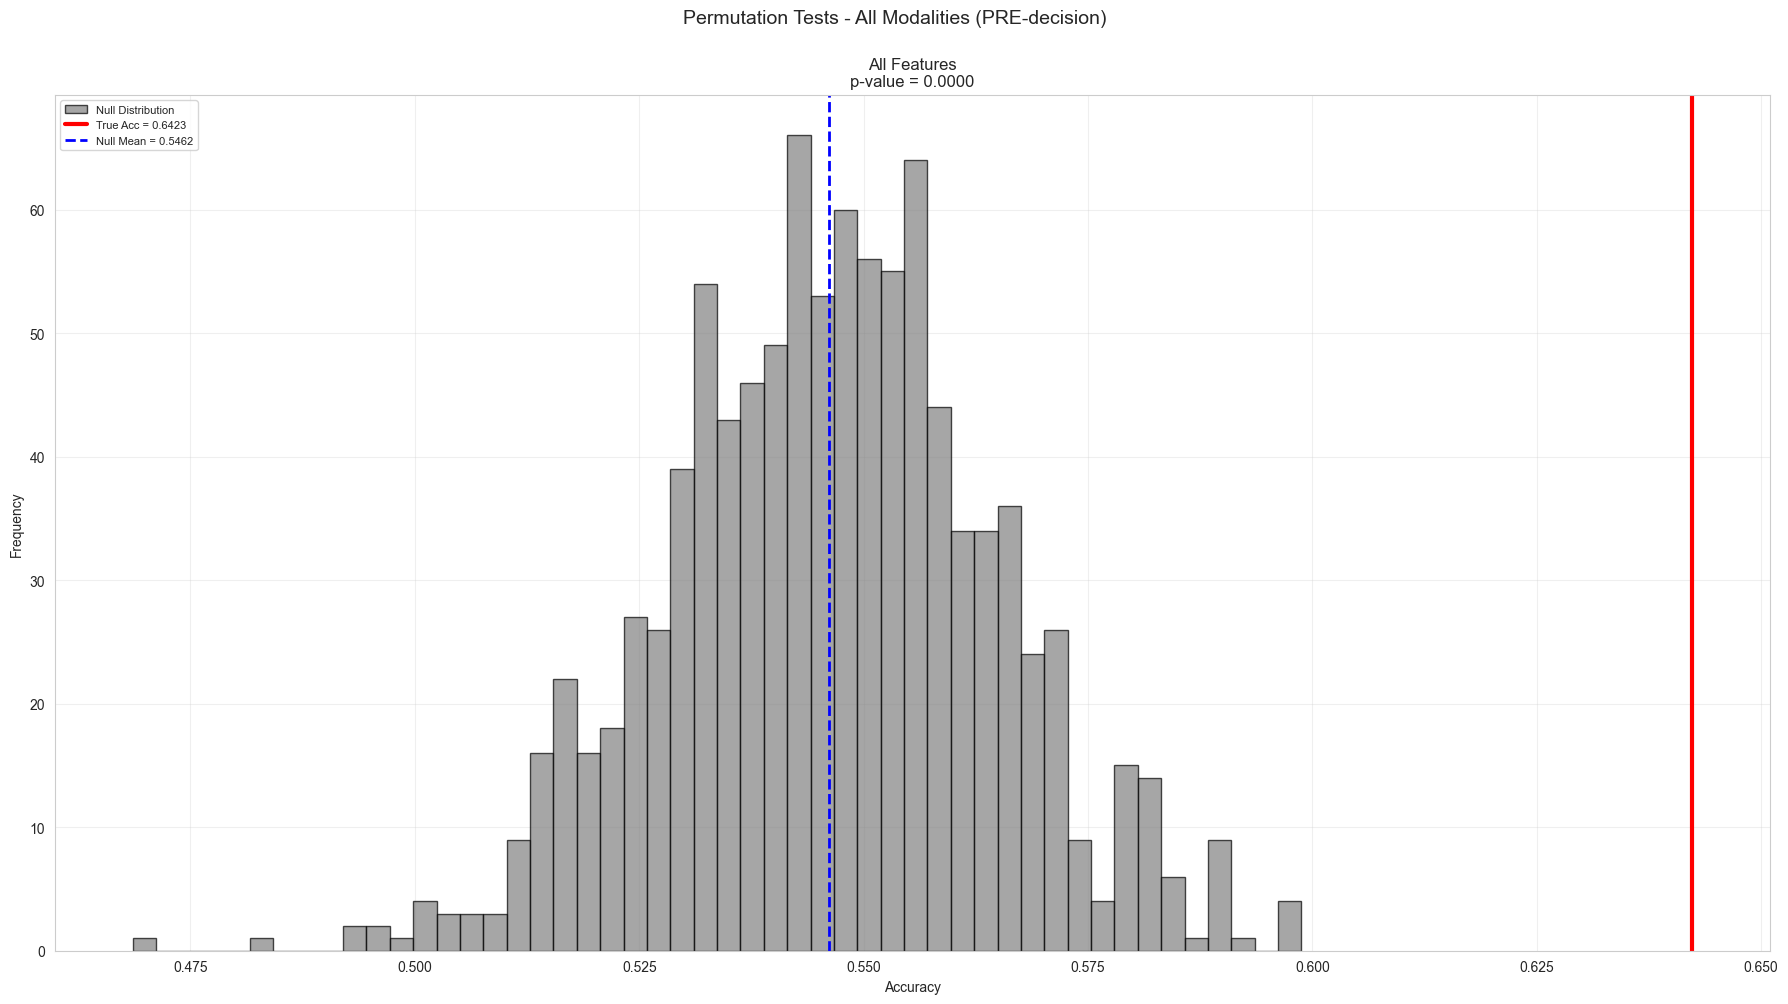


PERMUTATION TEST SUMMARY
       Model  True Accuracy  Null Mean  p-value Significant
All Features       0.642268   0.546172      0.0         Yes


In [10]:
# Visualize permutation tests for all modalities
fig, axes = plt.subplots(1, 1, figsize=(18, 10))

modalities = ['all']
titles = ['All Features']

for idx, (modality, title) in enumerate(zip(modalities, titles)):
    ax = axes
    result = perm_results[modality]
    
    ax.hist(result['null_distribution'], bins=50, alpha=0.7, 
            color='gray', edgecolor='black', label='Null Distribution')
    ax.axvline(result['true_accuracy'], color='red', linewidth=3, 
              label=f"True Acc = {result['true_accuracy']:.4f}")
    ax.axvline(result['null_mean'], color='blue', linewidth=2, 
              linestyle='--', label=f"Null Mean = {result['null_mean']:.4f}")
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Frequency')
    ax.set_title(f"{title}\np-value = {result['p_value']:.4f}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Permutation Tests - All Modalities ({TIMEFRAME}-decision)', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/permutation_tests_all_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*70)
print("PERMUTATION TEST SUMMARY")
print("="*70)
perm_summary = pd.DataFrame({
    'Model': titles,
    'True Accuracy': [perm_results[m]['true_accuracy'] for m in modalities],
    'Null Mean': [perm_results[m]['null_mean'] for m in modalities],
    'p-value': [perm_results[m]['p_value'] for m in modalities],
    'Significant': ['Yes' if perm_results[m]['p_value'] < 0.05 else 'No' for m in modalities]
})
print(perm_summary.to_string(index=False))

## 2. Bootstrap Confidence Intervals

**Goal:** Estimate 95% CI for accuracy and F1-score

**Method:** Resample subjects with replacement 1000 times

In [11]:
def bootstrap_ci(X, y, subjects, n_bootstrap=1000, model_name="Model"):
    """
    Optimized bootstrap confidence intervals for accuracy and F1-score.
    
    Uses class_weight='balanced' to handle class imbalance.
    """
    print(f"\n{'='*70}")
    print(f"Bootstrap Confidence Intervals: {model_name}")
    print(f"{'='*70}")
    
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    
    boot_accs = []
    boot_f1s = []
    
    # Sample ~30 subjects per bootstrap iteration for speed
    sample_size = min(30, n_subjects)
    
    print(f"Bootstrap strategy: Sampling {sample_size}/{n_subjects} subjects per iteration")
    print(f"Using class_weight='balanced' in all models")
    
    for i in tqdm(range(n_bootstrap), desc="Bootstrap iterations"):
        # Resample subjects with replacement
        boot_subjects = np.random.choice(unique_subjects, size=sample_size, replace=True)
        
        # Create bootstrap sample
        boot_mask = np.isin(subjects, boot_subjects)
        X_boot = X[boot_mask]
        y_boot = y[boot_mask]
        subjects_boot = subjects[boot_mask]
        
        # Skip if we don't have enough subjects
        if len(np.unique(subjects_boot)) < 5:
            continue
        
        # LOSO CV on bootstrap sample
        logo = LeaveOneGroupOut()
        fold_accs = []
        fold_f1s = []
        
        for train_idx, test_idx in logo.split(X_boot, y_boot, subjects_boot):
            X_train, X_test = X_boot[train_idx], X_boot[test_idx]
            y_train, y_test = y_boot[train_idx], y_boot[test_idx]
            
            # Skip folds with single class
            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                continue
            
            # Use class_weight='balanced'
            model = RandomForestClassifier(n_estimators=50, max_depth=5,
                                          min_samples_split=10, min_samples_leaf=5,
                                          class_weight='balanced',
                                          random_state=i, n_jobs=1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            fold_accs.append(accuracy_score(y_test, y_pred))
            fold_f1s.append(f1_score(y_test, y_pred, average='weighted'))
        
        # Only add if we got valid results
        if len(fold_accs) > 0:
            boot_accs.append(np.mean(fold_accs))
            boot_f1s.append(np.mean(fold_f1s))
    
    # Compute 95% CI
    acc_ci = np.percentile(boot_accs, [2.5, 97.5])
    f1_ci = np.percentile(boot_f1s, [2.5, 97.5])
    
    print(f"\nCompleted {len(boot_accs)} valid bootstrap iterations")
    print(f"Accuracy: {np.mean(boot_accs):.4f} (95% CI: {acc_ci[0]:.4f}-{acc_ci[1]:.4f})")
    print(f"F1-Score: {np.mean(boot_f1s):.4f} (95% CI: {f1_ci[0]:.4f}-{f1_ci[1]:.4f})")
    
    return {
        'accuracy_mean': np.mean(boot_accs),
        'accuracy_ci': acc_ci,
        'f1_mean': np.mean(boot_f1s),
        'f1_ci': f1_ci,
        'boot_accs': boot_accs,
        'boot_f1s': boot_f1s
    }

In [12]:
# Run bootstrap for all modalities
print("="*70)
print("RUNNING BOOTSTRAP CONFIDENCE INTERVALS FOR ALL MODALITIES")
print("="*70)

boot_results = {}
boot_results['all'] = bootstrap_ci(
    X_all, y, subjects, 
    n_bootstrap=1000, 
    model_name=f"All Features ({TIMEFRAME})"
)

RUNNING BOOTSTRAP CONFIDENCE INTERVALS FOR ALL MODALITIES

Bootstrap Confidence Intervals: All Features (PRE)
Bootstrap strategy: Sampling 30/97 subjects per iteration
Using class_weight='balanced' in all models


Bootstrap iterations: 100%|██████████| 1000/1000 [11:24:05<00:00, 41.05s/it]    


Completed 1000 valid bootstrap iterations
Accuracy: 0.6244 (95% CI: 0.5631-0.6790)
F1-Score: 0.6263 (95% CI: 0.5565-0.6854)


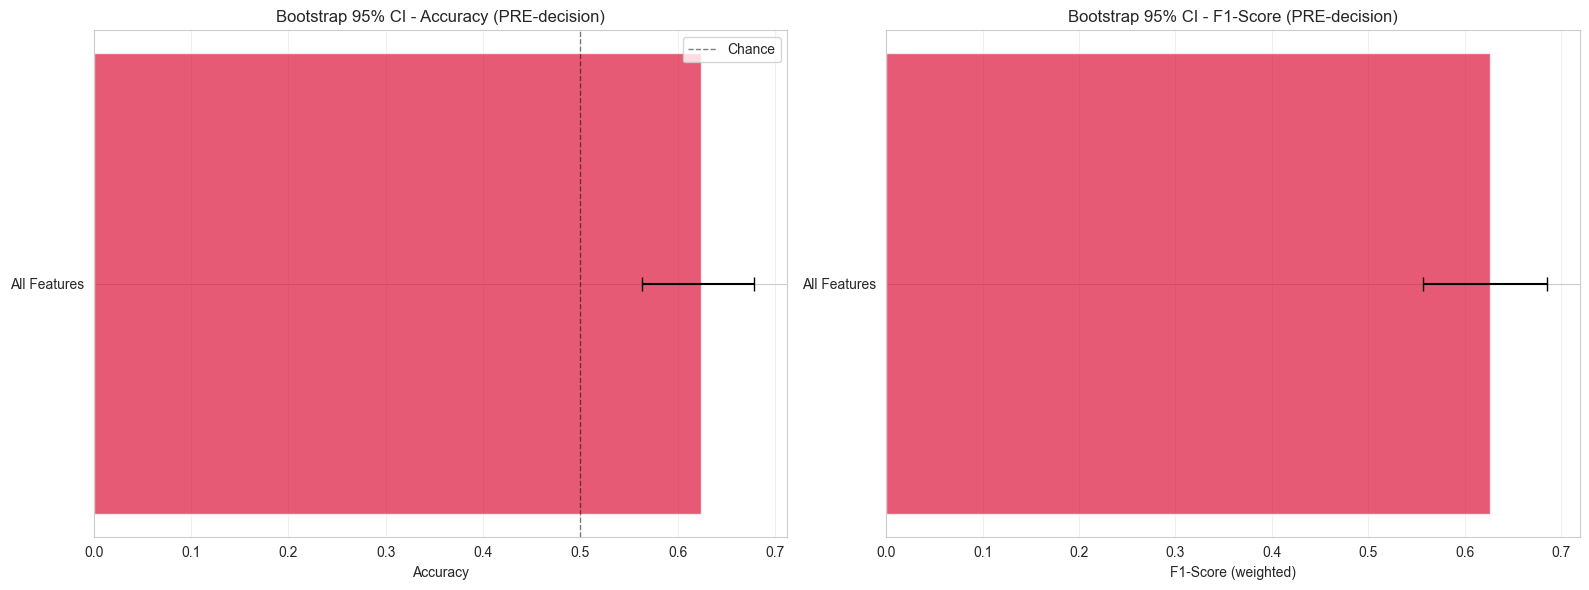


BOOTSTRAP CONFIDENCE INTERVALS SUMMARY
       Model Accuracy Accuracy 95% CI F1-Score       F1 95% CI
All Features   0.6244 (0.5631-0.6790)   0.6263 (0.5565-0.6854)


In [13]:
# Visualize bootstrap confidence intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

modalities = ['all']
titles = ['All Features']
colors = ['crimson']

# Accuracy plot
acc_means = [boot_results[m]['accuracy_mean'] for m in modalities]
acc_cis = [boot_results[m]['accuracy_ci'] for m in modalities]
acc_errors = [[acc_means[i] - acc_cis[i][0], acc_cis[i][1] - acc_means[i]] for i in range(len(modalities))]

ax1.barh(titles, acc_means, xerr=np.array(acc_errors).T, color=colors, alpha=0.7, capsize=5)
ax1.set_xlabel('Accuracy')
ax1.set_title(f'Bootstrap 95% CI - Accuracy ({TIMEFRAME}-decision)')
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(0.5, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Chance')
ax1.legend()

# F1-score plot
f1_means = [boot_results[m]['f1_mean'] for m in modalities]
f1_cis = [boot_results[m]['f1_ci'] for m in modalities]
f1_errors = [[f1_means[i] - f1_cis[i][0], f1_cis[i][1] - f1_means[i]] for i in range(len(modalities))]

ax2.barh(titles, f1_means, xerr=np.array(f1_errors).T, color=colors, alpha=0.7, capsize=5)
ax2.set_xlabel('F1-Score (weighted)')
ax2.set_title(f'Bootstrap 95% CI - F1-Score ({TIMEFRAME}-decision)')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/bootstrap_ci_all_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*70)
print("BOOTSTRAP CONFIDENCE INTERVALS SUMMARY")
print("="*70)
boot_summary = pd.DataFrame({
    'Model': titles,
    'Accuracy': [f"{boot_results[m]['accuracy_mean']:.4f}" for m in modalities],
    'Accuracy 95% CI': [f"({boot_results[m]['accuracy_ci'][0]:.4f}-{boot_results[m]['accuracy_ci'][1]:.4f})" for m in modalities],
    'F1-Score': [f"{boot_results[m]['f1_mean']:.4f}" for m in modalities],
    'F1 95% CI': [f"({boot_results[m]['f1_ci'][0]:.4f}-{boot_results[m]['f1_ci'][1]:.4f})" for m in modalities]
})
print(boot_summary.to_string(index=False))

## 3. McNemar's Test: Compare Models

**Goal:** Test if differences between models are statistically significant

**Comparisons:**
1. Combined vs Behavior Only
2. Combined vs Gaze Only  
3. Combined vs Physiology Only
4. Behavior vs Gaze
5. Behavior vs Physiology
6. Gaze vs Physiology

In [14]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, pred_model1, pred_model2, model1_name, model2_name):
    """
    McNemar's test to compare two models.
    
    Tests whether the two models make significantly different errors.
    Null hypothesis: Both models have the same error rate.
    """
    # Create contingency table
    # Format: [[both_correct, model1_correct_model2_wrong],
    #          [model1_wrong_model2_correct, both_wrong]]
    
    both_correct = np.sum((pred_model1 == y_true) & (pred_model2 == y_true))
    model1_correct = np.sum((pred_model1 == y_true) & (pred_model2 != y_true))
    model2_correct = np.sum((pred_model1 != y_true) & (pred_model2 == y_true))
    both_wrong = np.sum((pred_model1 != y_true) & (pred_model2 != y_true))
    
    contingency_table = np.array([[both_correct, model1_correct],
                                  [model2_correct, both_wrong]])
    
    # Run McNemar's test
    result = mcnemar(contingency_table, exact=False, correction=True)
    
    # Calculate accuracies
    acc1 = accuracy_score(y_true, pred_model1)
    acc2 = accuracy_score(y_true, pred_model2)
    
    print(f"\n{'='*70}")
    print(f"McNemar's Test: {model1_name} vs {model2_name}")
    print(f"{'='*70}")
    print(f"\nModel Accuracies:")
    print(f"  {model1_name}: {acc1:.4f}")
    print(f"  {model2_name}: {acc2:.4f}")
    print(f"  Difference: {abs(acc1 - acc2):.4f}")
    print(f"\nContingency Table:")
    print(f"  Both correct: {both_correct}")
    print(f"  Only {model1_name} correct: {model1_correct}")
    print(f"  Only {model2_name} correct: {model2_correct}")
    print(f"  Both wrong: {both_wrong}")
    print(f"\nMcNemar Test Results:")
    print(f"  Test statistic: {result.statistic:.4f}")
    print(f"  p-value: {result.pvalue:.4f}")
    
    if result.pvalue < 0.001:
        print(f"✓ Difference is HIGHLY SIGNIFICANT (p < 0.001)")
    elif result.pvalue < 0.01:
        print(f"✓ Difference is VERY SIGNIFICANT (p < 0.01)")
    elif result.pvalue < 0.05:
        print(f"✓ Difference is SIGNIFICANT (p < 0.05)")
    else:
        print(f"✗ Difference is NOT SIGNIFICANT (p = {result.pvalue:.4f})")
    
    return {
        'statistic': result.statistic,
        'pvalue': result.pvalue,
        'contingency_table': contingency_table,
        'acc1': acc1,
        'acc2': acc2
    }

## Generate Predictions for All Models

We need predictions from all models to run McNemar's test comparisons.

In [15]:
# Generate predictions from all models using LOSO CV
from sklearn.model_selection import LeaveOneGroupOut

def get_model_predictions(X, y, subjects):
    """Get predictions from LOSO cross-validation with class_weight='balanced'."""
    logo = LeaveOneGroupOut()
    model = RandomForestClassifier(n_estimators=100, max_depth=5, 
                                  min_samples_split=10, min_samples_leaf=5,
                                  class_weight='balanced',
                                  random_state=42, n_jobs=-1)
    
    preds_all = []
    y_true_all = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    return np.array(preds_all), np.array(y_true_all)

print("Generating predictions for all models...")
print("⚠️  Using class_weight='balanced' (different from other notebooks!)")
print("This will take several minutes...\n")

# Generate predictions for all modalities
pred_physio, y_true = get_model_predictions(X_physiology, y, subjects)
print(f"✓ Physiology model - Accuracy: {accuracy_score(y_true, pred_physio):.4f}")

pred_gaze, _ = get_model_predictions(X_gaze, y, subjects)
print(f"✓ Gaze model - Accuracy: {accuracy_score(y_true, pred_gaze):.4f}")

pred_behavior, _ = get_model_predictions(X_behavior, y, subjects)
print(f"✓ Behavior model - Accuracy: {accuracy_score(y_true, pred_behavior):.4f}")

pred_phys_gaze, _ = get_model_predictions(X_phys_gaze, y, subjects)
print(f"✓ Physiology + Gaze model - Accuracy: {accuracy_score(y_true, pred_phys_gaze):.4f}")

pred_all, _ = get_model_predictions(X_all, y, subjects)
print(f"✓ All features model - Accuracy: {accuracy_score(y_true, pred_all):.4f}")

print("\n✓ All predictions generated!")
print("\n⚠️  Remember to add class_weight='balanced' to all other modeling notebooks!")

Generating predictions for all models...
⚠️  Using class_weight='balanced' (different from other notebooks!)
This will take several minutes...

✓ Physiology model - Accuracy: 0.5148
✓ Gaze model - Accuracy: 0.5020
✓ Behavior model - Accuracy: 0.6543
✓ Physiology + Gaze model - Accuracy: 0.5150
✓ All features model - Accuracy: 0.6515

✓ All predictions generated!

⚠️  Remember to add class_weight='balanced' to all other modeling notebooks!


In [16]:
# Run all pairwise comparisons
print("\n" + "="*70)
print("MCNEMAR'S TESTS: PAIRWISE MODEL COMPARISONS")
print("="*70)

# Store all results
mcnemar_results = {}

# 1. All Features vs individual modalities
mcnemar_results['all_vs_physio'] = mcnemar_test(
    y_true, pred_all, pred_physio, 
    "All Features", "Physiology"
)

mcnemar_results['all_vs_gaze'] = mcnemar_test(
    y_true, pred_all, pred_gaze,
    "All Features", "Gaze"
)

mcnemar_results['all_vs_behavior'] = mcnemar_test(
    y_true, pred_all, pred_behavior, 
    "All Features", "Behavior"
)

mcnemar_results['all_vs_phys_gaze'] = mcnemar_test(
    y_true, pred_all, pred_phys_gaze,
    "All Features", "Physiology+Gaze"
)

# 2. Physiology+Gaze vs individual modalities
mcnemar_results['phys_gaze_vs_physio'] = mcnemar_test(
    y_true, pred_phys_gaze, pred_physio,
    "Physiology+Gaze", "Physiology"
)

mcnemar_results['phys_gaze_vs_gaze'] = mcnemar_test(
    y_true, pred_phys_gaze, pred_gaze,
    "Physiology+Gaze", "Gaze"
)

mcnemar_results['phys_gaze_vs_behavior'] = mcnemar_test(
    y_true, pred_phys_gaze, pred_behavior,
    "Physiology+Gaze", "Behavior"
)

# 3. Between individual modalities
mcnemar_results['physio_vs_gaze'] = mcnemar_test(
    y_true, pred_physio, pred_gaze,
    "Physiology", "Gaze"
)

mcnemar_results['physio_vs_behavior'] = mcnemar_test(
    y_true, pred_physio, pred_behavior,
    "Physiology", "Behavior"
)

mcnemar_results['gaze_vs_behavior'] = mcnemar_test(
    y_true, pred_gaze, pred_behavior,
    "Gaze", "Behavior"
)


MCNEMAR'S TESTS: PAIRWISE MODEL COMPARISONS

McNemar's Test: All Features vs Physiology

Model Accuracies:
  All Features: 0.6515
  Physiology: 0.5148
  Difference: 0.1367

Contingency Table:
  Both correct: 5142
  Only All Features correct: 3009
  Only Physiology correct: 1299
  Both wrong: 3061

McNemar Test Results:
  Test statistic: 677.9668
  p-value: 0.0000
✓ Difference is HIGHLY SIGNIFICANT (p < 0.001)

McNemar's Test: All Features vs Gaze

Model Accuracies:
  All Features: 0.6515
  Gaze: 0.5020
  Difference: 0.1495

Contingency Table:
  Both correct: 4554
  Only All Features correct: 3597
  Only Gaze correct: 1727
  Both wrong: 2633

McNemar Test Results:
  Test statistic: 656.1159
  p-value: 0.0000
✓ Difference is HIGHLY SIGNIFICANT (p < 0.001)

McNemar's Test: All Features vs Behavior

Model Accuracies:
  All Features: 0.6515
  Behavior: 0.6543
  Difference: 0.0028

Contingency Table:
  Both correct: 7518
  Only All Features correct: 633
  Only Behavior correct: 668
  Both w


MCNEMAR'S TEST SUMMARY
                     Comparison  Accuracy_1  Accuracy_2  Difference       p_value Significant
     All Features vs Physiology    0.651507    0.514827    0.136680 1.849593e-149         Yes
           All Features vs Gaze    0.651507    0.502038    0.149468 1.044805e-144         Yes
       All Features vs Behavior    0.651507    0.654304    0.002798  3.458713e-01          No
All Features vs Physiology+Gaze    0.651507    0.514987    0.136520 1.057811e-150         Yes
  Physiology+Gaze vs Physiology    0.514987    0.514827    0.000160  9.750702e-01          No
        Physiology+Gaze vs Gaze    0.514987    0.502038    0.012949  1.448468e-02         Yes
    Physiology+Gaze vs Behavior    0.514987    0.654304    0.139317 6.904398e-127         Yes
             Physiology vs Gaze    0.514827    0.502038    0.012789  2.399600e-02         Yes
         Physiology vs Behavior    0.514827    0.654304    0.139477 2.791582e-126         Yes
               Gaze vs Behavior    0

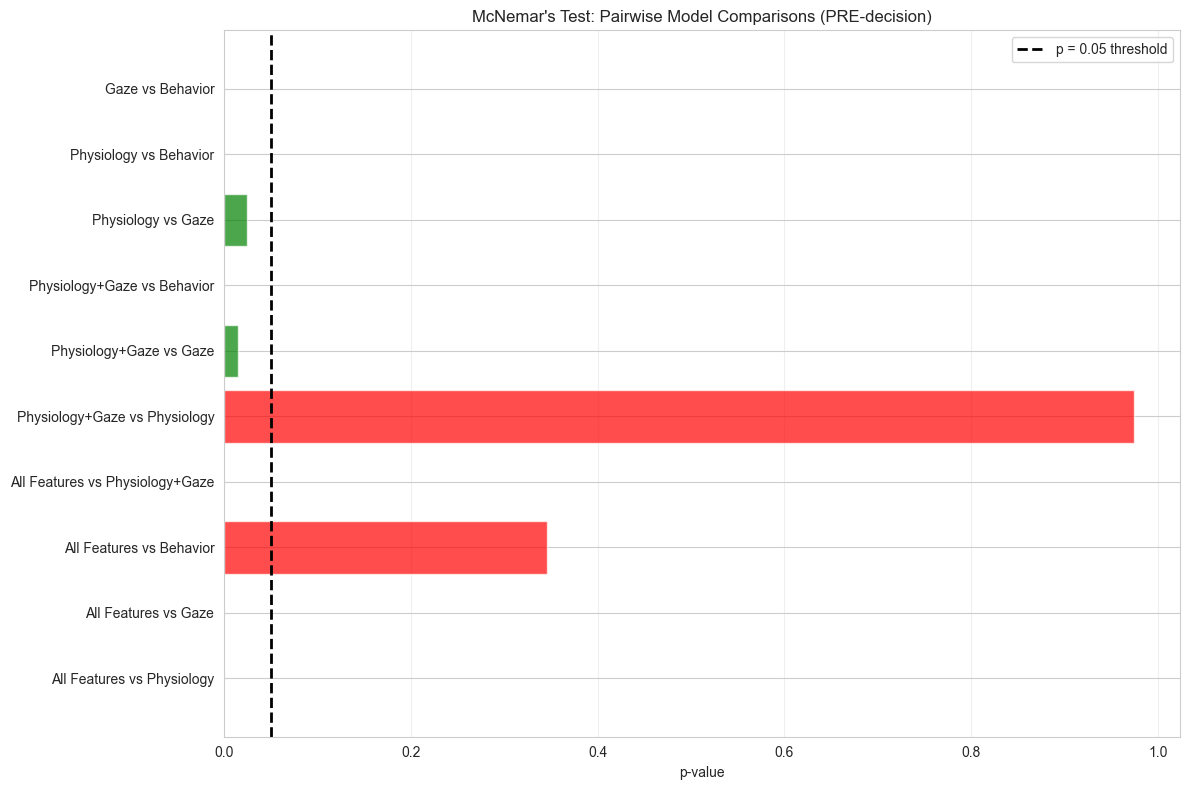

In [17]:
# Create summary table for McNemar's tests
comparison_names = [
    'All Features vs Physiology',
    'All Features vs Gaze',
    'All Features vs Behavior',
    'All Features vs Physiology+Gaze',
    'Physiology+Gaze vs Physiology',
    'Physiology+Gaze vs Gaze',
    'Physiology+Gaze vs Behavior',
    'Physiology vs Gaze',
    'Physiology vs Behavior',
    'Gaze vs Behavior'
]

result_keys = [
    'all_vs_physio', 'all_vs_gaze', 'all_vs_behavior', 'all_vs_phys_gaze',
    'phys_gaze_vs_physio', 'phys_gaze_vs_gaze', 'phys_gaze_vs_behavior',
    'physio_vs_gaze', 'physio_vs_behavior', 'gaze_vs_behavior'
]

mcnemar_summary = pd.DataFrame({
    'Comparison': comparison_names,
    'Accuracy_1': [mcnemar_results[k]['acc1'] for k in result_keys],
    'Accuracy_2': [mcnemar_results[k]['acc2'] for k in result_keys],
    'Difference': [abs(mcnemar_results[k]['acc1'] - mcnemar_results[k]['acc2']) for k in result_keys],
    'p_value': [mcnemar_results[k]['pvalue'] for k in result_keys],
    'Significant': ['Yes' if mcnemar_results[k]['pvalue'] < 0.05 else 'No' for k in result_keys]
})

print("\n" + "="*70)
print("MCNEMAR'S TEST SUMMARY")
print("="*70)
print(mcnemar_summary.to_string(index=False))

# Save McNemar results
mcnemar_summary.to_csv(f'../../data/results/analysis_outputs_{TIMEFRAME}/mcnemar_test_summary_{TIMEFRAME}.csv', index=False)
print(f"\n✓ Saved McNemar's test summary to analysis_outputs_{TIMEFRAME}/mcnemar_test_summary_{TIMEFRAME}.csv")

# Visualize p-values
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['green' if p < 0.05 else 'red' for p in mcnemar_summary['p_value']]
bars = ax.barh(mcnemar_summary['Comparison'], mcnemar_summary['p_value'], color=colors, alpha=0.7)
ax.axvline(0.05, color='black', linestyle='--', linewidth=2, label='p = 0.05 threshold')
ax.set_xlabel('p-value')
ax.set_title(f"McNemar's Test: Pairwise Model Comparisons ({TIMEFRAME}-decision)")
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/mcnemar_pvalues_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## 4. Repeated Measures ANOVA: Ambiguity Effects

**Goal:** Test if decision accuracy varies significantly across ambiguity levels

**Method:** One-way repeated measures ANOVA on subject accuracies from Low, Medium, and High ambiguity groups

In [18]:
# Load subject-level accuracies from ambiguity group analysis
print("="*70)
print("LOADING AMBIGUITY GROUP DATA")
print("="*70)

# Load subject accuracies for each ambiguity group
low_accs = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_Low_subject_accuracies.csv')
medium_accs = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_Medium_subject_accuracies.csv')
high_accs = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_High_subject_accuracies.csv')

print(f"\nSubject counts per ambiguity group:")
print(f"  Low: {len(low_accs)} subjects")
print(f"  Medium: {len(medium_accs)} subjects")
print(f"  High: {len(high_accs)} subjects")

# Combine into long-form dataframe for ANOVA
ambiguity_data = pd.DataFrame({
    'Subject_ID': list(range(len(low_accs))) + list(range(len(medium_accs))) + list(range(len(high_accs))),
    'Ambiguity': ['Low'] * len(low_accs) + ['Medium'] * len(medium_accs) + ['High'] * len(high_accs),
    'Accuracy': list(low_accs['accuracy']) + list(medium_accs['accuracy']) + list(high_accs['accuracy'])
})

print(f"\nMean accuracy by ambiguity group:")
print(ambiguity_data.groupby('Ambiguity')['Accuracy'].agg(['mean', 'std', 'sem']))

# Perform one-way repeated measures ANOVA
from scipy.stats import f_oneway

print(f"\n{'='*70}")
print("REPEATED MEASURES ANOVA: AMBIGUITY EFFECT ON ACCURACY")
print(f"{'='*70}")

# Run one-way ANOVA
f_stat, p_value = f_oneway(
    low_accs['accuracy'],
    medium_accs['accuracy'],
    high_accs['accuracy']
)

# Calculate degrees of freedom
df_between = 2  # 3 groups - 1
df_within = len(ambiguity_data) - 3  # total observations - number of groups

print(f"\nANOVA Results:")
print(f"  F-statistic: F({df_between},{df_within}) = {f_stat:.3f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.001:
    print(f"\n✓ Ambiguity has a HIGHLY SIGNIFICANT effect on accuracy (p < 0.001)")
elif p_value < 0.01:
    print(f"\n✓ Ambiguity has a VERY SIGNIFICANT effect on accuracy (p < 0.01)")
elif p_value < 0.05:
    print(f"\n✓ Ambiguity has a SIGNIFICANT effect on accuracy (p < 0.05)")
else:
    print(f"\n✗ Ambiguity does NOT have a significant effect on accuracy (p = {p_value:.4f})")

# Store results
anova_results = {
    'f_statistic': f_stat,
    'df_between': df_between,
    'df_within': df_within,
    'p_value': p_value,
    'data': ambiguity_data
}

LOADING AMBIGUITY GROUP DATA

Subject counts per ambiguity group:
  Low: 97 subjects
  Medium: 97 subjects
  High: 97 subjects

Mean accuracy by ambiguity group:
               mean       std       sem
Ambiguity                              
High       0.529210  0.295618  0.030015
Low        0.827320  0.261109  0.026512
Medium     0.690722  0.349429  0.035479

REPEATED MEASURES ANOVA: AMBIGUITY EFFECT ON ACCURACY

ANOVA Results:
  F-statistic: F(2,288) = 23.338
  p-value: 0.0000

✓ Ambiguity has a HIGHLY SIGNIFICANT effect on accuracy (p < 0.001)


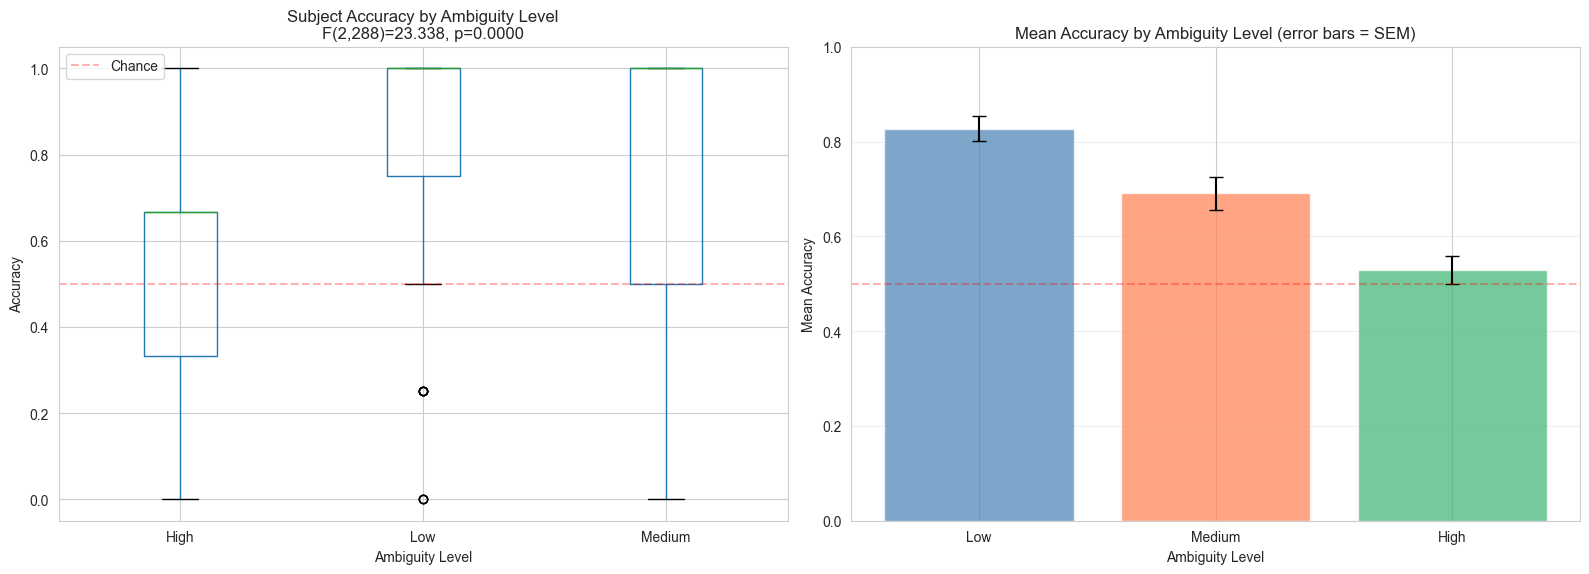


✓ Saved ambiguity ANOVA visualization to figures/ambiguity_anova_PRE.png


In [19]:
# Visualize ambiguity effect on accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
ambiguity_data.boxplot(column='Accuracy', by='Ambiguity', ax=ax1)
ax1.set_xlabel('Ambiguity Level')
ax1.set_ylabel('Accuracy')
ax1.set_title(f'Subject Accuracy by Ambiguity Level\nF({df_between},{df_within})={f_stat:.3f}, p={p_value:.4f}')
ax1.axhline(0.5, color='red', linestyle='--', alpha=0.3, label='Chance')
ax1.legend()
plt.suptitle('')  # Remove default title

# Bar plot with error bars
summary = ambiguity_data.groupby('Ambiguity')['Accuracy'].agg(['mean', 'sem']).reset_index()
summary = summary.set_index('Ambiguity').reindex(['Low', 'Medium', 'High']).reset_index()
ax2.bar(summary['Ambiguity'], summary['mean'], yerr=summary['sem'], 
        capsize=5, alpha=0.7, color=['steelblue', 'coral', 'mediumseagreen'])
ax2.set_xlabel('Ambiguity Level')
ax2.set_ylabel('Mean Accuracy')
ax2.set_title('Mean Accuracy by Ambiguity Level (error bars = SEM)')
ax2.set_ylim([0, 1])
ax2.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/ambiguity_anova_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved ambiguity ANOVA visualization to figures/ambiguity_anova_{TIMEFRAME}.png")

## Summary Table: All Statistical Tests

In [20]:
# Create comprehensive summary table
modalities = ['all']
modality_names = ['All Features']

summary_rows = []

# Add permutation test results
for mod, name in zip(modalities, modality_names):
    summary_rows.append({
        'Test': f'Permutation Test ({name})',
        'Result': f"p = {perm_results[mod]['p_value']:.4f}",
        'Interpretation': 'Significantly > chance' if perm_results[mod]['p_value'] < 0.05 else 'Not significant'
    })

summary_rows.append({'Test': '', 'Result': '', 'Interpretation': ''})

# Add bootstrap CI results
for mod, name in zip(modalities, modality_names):
    summary_rows.append({
        'Test': f'Bootstrap CI - Accuracy ({name})',
        'Result': f"{boot_results[mod]['accuracy_mean']:.4f} ({boot_results[mod]['accuracy_ci'][0]:.4f}-{boot_results[mod]['accuracy_ci'][1]:.4f})",
        'Interpretation': '95% confidence interval'
    })

summary_rows.append({'Test': '', 'Result': '', 'Interpretation': ''})

for mod, name in zip(modalities, modality_names):
    summary_rows.append({
        'Test': f'Bootstrap CI - F1-Score ({name})',
        'Result': f"{boot_results[mod]['f1_mean']:.4f} ({boot_results[mod]['f1_ci'][0]:.4f}-{boot_results[mod]['f1_ci'][1]:.4f})",
        'Interpretation': '95% confidence interval'
    })

summary_rows.append({'Test': '', 'Result': '', 'Interpretation': ''})

# Add McNemar tests
for comp_name, key in zip(comparison_names, result_keys):
    summary_rows.append({
        'Test': f"McNemar: {comp_name}",
        'Result': f"p = {mcnemar_results[key]['pvalue']:.4f}",
        'Interpretation': 'Significant' if mcnemar_results[key]['pvalue'] < 0.05 else 'Not significant'
    })

summary_rows.append({'Test': '', 'Result': '', 'Interpretation': ''})

# Add ANOVA results
summary_rows.append({
    'Test': 'ANOVA: Ambiguity Effect on Accuracy',
    'Result': f"F({anova_results['df_between']},{anova_results['df_within']}) = {anova_results['f_statistic']:.3f}, p = {anova_results['p_value']:.4f}",
    'Interpretation': 'Highly significant' if anova_results['p_value'] < 0.001 else ('Significant' if anova_results['p_value'] < 0.05 else 'Not significant')
})

summary_df = pd.DataFrame(summary_rows)

print("\n" + "="*70)
print(f"COMPREHENSIVE STATISTICAL TESTING SUMMARY ({TIMEFRAME}-DECISION)")
print("="*70)
print(summary_df.to_string(index=False))

# Save comprehensive summary
summary_df.to_csv(f'../../data/results/analysis_outputs_{TIMEFRAME}/statistical_testing_summary_{TIMEFRAME}.csv', index=False)
print(f"\n✓ Saved comprehensive summary to: statistical_testing_summary_{TIMEFRAME}.csv")


COMPREHENSIVE STATISTICAL TESTING SUMMARY (PRE-DECISION)
                                    Test                        Result          Interpretation
         Permutation Test (All Features)                    p = 0.0000  Significantly > chance
                                                                                              
  Bootstrap CI - Accuracy (All Features)        0.6244 (0.5631-0.6790) 95% confidence interval
                                                                                              
  Bootstrap CI - F1-Score (All Features)        0.6263 (0.5565-0.6854) 95% confidence interval
                                                                                              
     McNemar: All Features vs Physiology                    p = 0.0000             Significant
           McNemar: All Features vs Gaze                    p = 0.0000             Significant
       McNemar: All Features vs Behavior                    p = 0.3459         Not sign

In [21]:
# Save detailed results including all tests
stat_results = {
    'permutation_tests': perm_results,
    'bootstrap_ci': boot_results,
    'mcnemar_tests': mcnemar_results,
    'anova_test': anova_results,
    'summary': summary_df,
    'mcnemar_summary': mcnemar_summary,
    'perm_summary': perm_summary,
    'boot_summary': boot_summary
}

with open(f'../../data/results/analysis_outputs_{TIMEFRAME}/statistical_testing_results_{TIMEFRAME}.pkl', 'wb') as f:
    pickle.dump(stat_results, f)

print(f"✓ Saved all statistical test results to: statistical_testing_results_{TIMEFRAME}.pkl")
print(f"\n{'='*70}")
print("ANALYSIS COMPLETE!")
print(f"{'='*70}")
print(f"\nAll results saved to: ../../data/results/analysis_outputs_{TIMEFRAME}/")
print("\nGenerated files:")
print(f"  - mcnemar_test_summary_{TIMEFRAME}.csv")
print(f"  - statistical_testing_summary_{TIMEFRAME}.csv")
print(f"  - statistical_testing_results_{TIMEFRAME}.pkl")
print(f"  - figures/permutation_tests_all_{TIMEFRAME}.png")
print(f"  - figures/bootstrap_ci_all_{TIMEFRAME}.png")
print(f"  - figures/mcnemar_pvalues_{TIMEFRAME}.png")
print(f"  - figures/ambiguity_anova_{TIMEFRAME}.png")

✓ Saved all statistical test results to: statistical_testing_results_PRE.pkl

ANALYSIS COMPLETE!

All results saved to: ../../data/results/analysis_outputs_PRE/

Generated files:
  - mcnemar_test_summary_PRE.csv
  - statistical_testing_summary_PRE.csv
  - statistical_testing_results_PRE.pkl
  - figures/permutation_tests_all_PRE.png
  - figures/bootstrap_ci_all_PRE.png
  - figures/mcnemar_pvalues_PRE.png
  - figures/ambiguity_anova_PRE.png
